%%latex
\setcounter{page}{87}
\tableofcontents 
\setcounter{section}{0}

# Abstract
Experimental data from simultaneous work function and resistance measurements will be compared with the results from the numerical calculations. Results from an $SnO_2$ gas sensor measured at 300°C will be used to demonstrate, how numerical data can be used to gain more insights about the measured material. The chosen dataset the the graphical representation originates from the Phd. thesis of Julia Rebholz: <cite data-cite="Rebholz2016a">(Influence of Conduction Mechanism Changes and Related Effects on the Sensing Performance of Metal Oxide Based Gas Sensors, 2016)</cite>.

The data was generated by exposing the sensor to various gas compositions of $H_2$, $CO$, $O_2$ and $N_2$. The surface potential changes $\Delta V$ resulting from the different gas atmosphere have been obtained with the Kelvin probe technique. Simultaneously the corresponding resistance was measured.
The data point point at $0e\Delta V$ corresponds to the situation in nitrogen.

These experimental data points will be compared with the results obtained from the numerical model.

![](media/IPC1000undoped_RgegqdV.JPG)

\begin{center}
This figure shows the dependency of the resistance on the band bending changes for the undoped $SnO_2$ nanopower based gas sensor. $e\Delta=0$ is denoted as the situation in $N_2$
\end{center}

# Fitting experimental data to numerical results
## Importing experimental and numerical data
The data is saved in an excel file, which will be loaded by using the tools provided by `pandas`.

In [47]:
#Setting up the env.
from part2 import *
import pandas as pd
%pylab inline

#importing the data
calc_dF = pd.read_hdf('numerical_sol.h5','raw')
dF_1000 = pd.read_excel('Kelvin_Data.xlsx', sheet_name='ipc1000').sort_values(by='dV')

#instead of unsing the row number
#each row has the value of dV as index
dF_1000.index = dF_1000['dV']

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['linalg', 'random', 'fft', 'power']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Representing the raw data


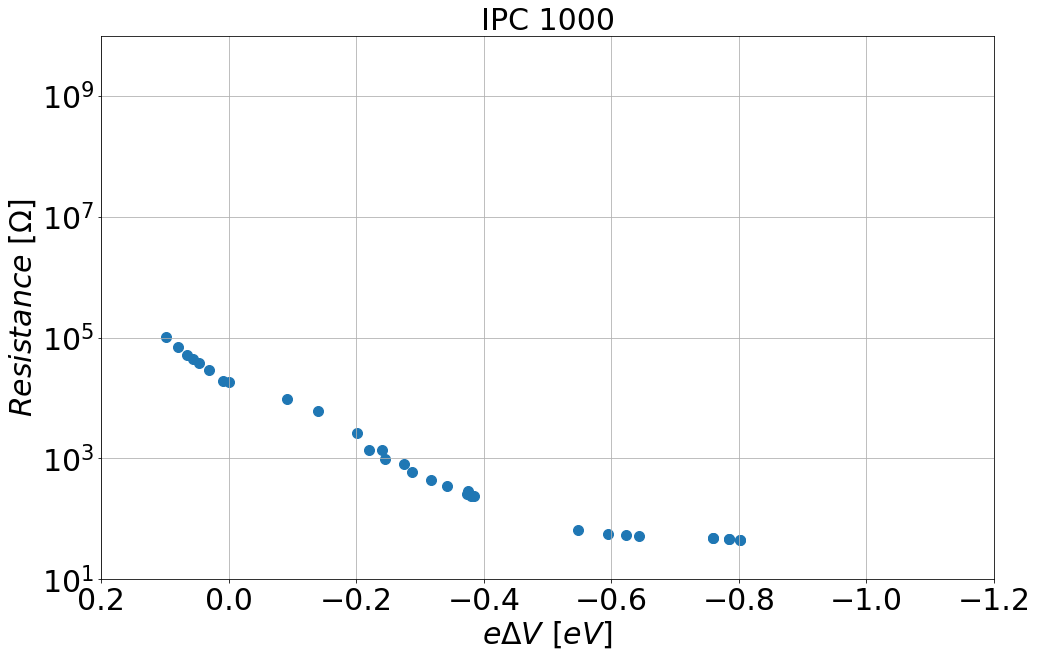

In [48]:
def format_axe(axe, ylabel = None, set_ylim=False):
    labelsize = 30
    if set_ylim:
        axe.set_ylim((1e-4,1e3))
    axe.set_yscale('log')
    axe.set_xlim((0.2,-1.2))
    if ylabel:
        axe.set_ylabel(ylabel, fontsize = labelsize)
    else:
        axe.set_ylabel(r'$\frac{R_{V_S}}{R_{(V_S=0)}}$', fontsize = labelsize)
    axe.set_xlabel('$e\Delta V$ $[eV]$', fontsize = labelsize)
    axe.tick_params(axis='both', which='both', labelsize=labelsize)
    axe.grid()

    
fig, axe = subplots(figsize=(16,10))

sens, dF = 'IPC 1000',dF_1000

v_exp = dF['dV']

res_exp = dF['res']
axe.set_title(sens, fontsize = 30)
axe.scatter(v_exp,res_exp, s=100)
format_axe(axe,ylabel='$Resistance$ [$\Omega$]')
axe.set_ylim(res_exp.min()/2,res_exp.max()*2);
axe.set_ylim(10,10e9);



\begin{center}
This figure represents the exprimental data as show before plotted in the Python environment.  The dependency of the resistance on the band bending changes is shown for the undoped $SnO_2$ nanopower based gas sensor. $q\Delta=0$ is denoted as the situation in $N_2$.
\end{center}

## From $R_{V_S}$ to $\Delta R_{V_S}$
In the experimental dataset the value at 0$qV_s$ represent the data points measured under nitrogen. Therefore $\Delta R_{V_S} =\frac{R_{V_S}}{R_{0}}$ is calculated by :

- First derive the resistance under nitrogen $R_{0}$
- Second devide all resitance values by this value



Text(0.5, 1.0, 'IPC 1000')

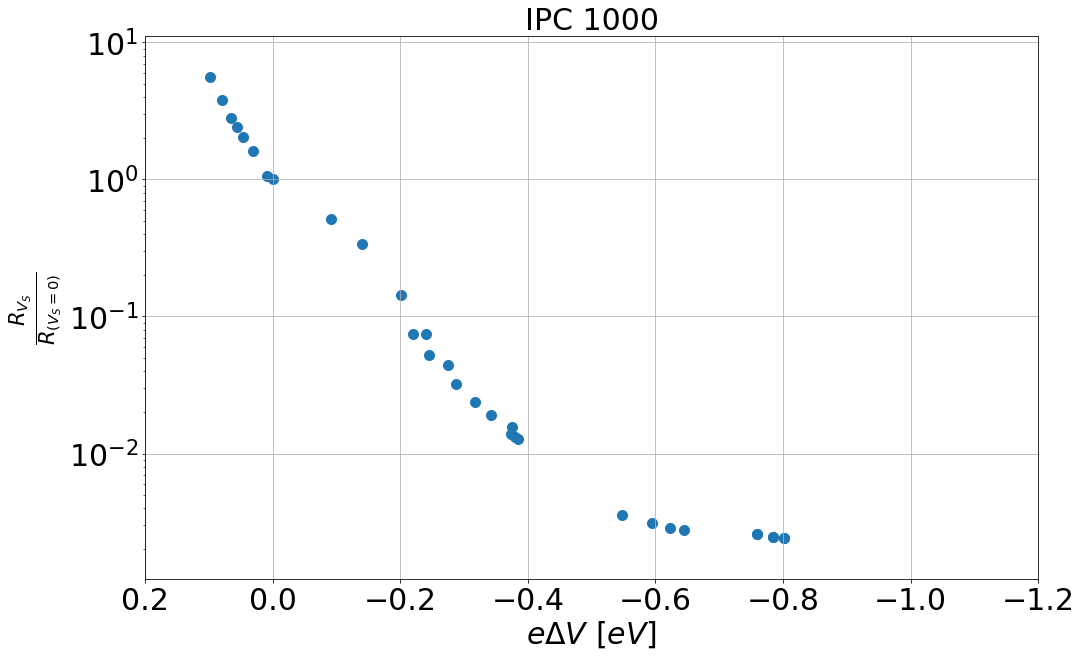

In [49]:
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d


fig, axe = subplots(1, figsize=(16,10))

#get the value of the flatband (if needed)
#by interpolation 
interp_res = interp1d(v_exp,res_exp)
res_flatband = interp_res(0)

#calcualte the rel. res change
rel_res_exp = dF['res']/res_flatband


#represent it
format_axe(axe)
axe.scatter(dF['dV'],rel_res_exp, s=100)
axe.set_ylim(rel_res_exp.min()/2,
             rel_res_exp.max()*2);
axe.set_title(sens, fontsize = 30)

\begin{center}
The resistances have been normalized to the resistance at $q\Delta=0$
\end{center}

## Interpolating the numerical values
In the previous section, the numerical solution for multiple start parameters have been calculated. Nevertheless most probably the calculated dataset will not hold exactly the same values gathered from the experiment. To obtain the numerical value for a specific experimental value of $qV_s$ a interpolation between of the existing numerical values will be used again.
For all different numerical grains $\Delta R_{{V_S}}$ will be calculated for all the experimental values of $qV_s$. Once this is done, the different between the numerical model and the exp. data can be calculated and evaluated.

In [50]:
#The dataframe to hold the different
#of the exp. values to the numerical ones
#Will be used to find the best fitting num. solution
num_data_at_exp_pos_dF = pd.DataFrame(index = v_exp)

#group the num. data by its paramters (T, R and ND)
data_by_grain = calc_dF.groupby(['temp','R','ND'])

for (T, R,ND), calc_dF_grain in data_by_grain:
    
    num_data_at_exp_pos_dF[(T, R,ND)] = None
    
    grain = create_grain_from_data(calc_dF_grain)
    
    flat_band_data = calc_dF_grain[calc_dF_grain['Einit_kT']==0].iloc[0]
        
    rel_res_num = calc_dF_grain['rel_res_change']
    
    #express the surace potential in eV
    #to be comparable with the exp. data
    v_num = calc_dF_grain['Einit_kT']*CONST.J_to_eV(grain.material.kT)
    
    #use interpolation to get the values for the positions
    #of the experiment data points
    interp_rs_num = interp1d(v_num, rel_res_num,bounds_error=False)
    interp_v_num = interp1d(rel_res_num,v_num, bounds_error=False)

    #caculate the numerical value of rel. res at the position
    # of V from the experiment
    res_num_at_exp_pos = interp_rs_num(v_exp)

    #save those values in the new DataFrame
    num_data_at_exp_pos_dF.loc[:,(T, R,ND)] = res_num_at_exp_pos


## Calculating the fit error
`num_data_at_exp_pos_dF` contains now the values of $\Delta R_{{V_S}}$ at the positions $qV_S$. From these values the relative error needs to be calculated. The following formula is used to derive the error:

\begin{align}
\epsilon_{V_S} = \left(\frac {R_{numerical}(qV_s)-R_{experiment}(qV_s)} {R_{experiment}(qV_s)}\right)^2
\end{align}

The sum of all $\epsilon_{V_S}$ is the total error of the fit. The numerical model with the lowest value of $\sum \epsilon_{V_S}$ is the model which fits best to the experimental data.
The average grain diameter of the material "IPC1000" is known to be in average radius of 55nm (diameter of 110nm)  <cite cite-data="Dieguez1999">(Nanoparticle engineering for gas sensor optimization: Improved sol-gel fabricated nanocrystalline SnO2 thick film gas sensor for NO2 detection by calcination, catalytic metal introduction and grinding treatments, 1999)</cite>. The dataset we created in the previous section includes models for grains with radii of 50nm and 100nm. Therefore we can narrow the fit algorithm down, to take only models with a radius of 50nm and 100nm in account

In [51]:
abs_error = num_data_at_exp_pos_dF.subtract(rel_res_exp, axis='index')
rel_error = abs_error.divide(rel_res_exp, axis='index')
rel_error_square = rel_error**2
sum_of_squares = rel_error_square.sum()

valid_index = [i for i in sum_of_squares.index if i[1] in [50e-9,100e-9]]

sum_of_squares_grainsize = sum_of_squares.loc[valid_index].sort_values()

grain_min_error_tuple = sum_of_squares_grainsize.idxmin()
best_fits_error_dF = pd.DataFrame({'error':sum_of_squares_grainsize})

T_temp = [i[0] for i in best_fits_error_dF.index]
R_temp = [i[1] for i in best_fits_error_dF.index]
ND_temp = [i[2] for i in best_fits_error_dF.index]
best_fits_error_dF['T'] = T_temp
best_fits_error_dF['Radius'] = R_temp
best_fits_error_dF['$N_D$'] = ND_temp
best_fits_error_dF.index = range(len(best_fits_error_dF))

display(best_fits_error_dF)

caption = Latex(r'''\begin{center}
Table with the best fit parameters
\end{center}''')
display(caption)

,error,T,Radius,$N_D$
0,6.822288,300.0,5.000000e-08,1.000000e+22
1,7.665906,300.0,1.000000e-07,1.000000e+22
2,14.358742,300.0,1.000000e-07,1.000000e+21
3,18.771491,300.0,5.000000e-08,1.000000e+21
4,175.204658,300.0,5.000000e-08,1.000000e+23
5,1256.744498,300.0,1.000000e-07,1.000000e+23
6,9905.878196,300.0,5.000000e-08,1.000000e+24
7,39709.781227,300.0,1.000000e-07,1.000000e+24


<IPython.core.display.Latex object>

## Representation of the fit
Finally the best fit results can be represented graphically. 


Text(0.5, 1.0, 'IPC 1000')

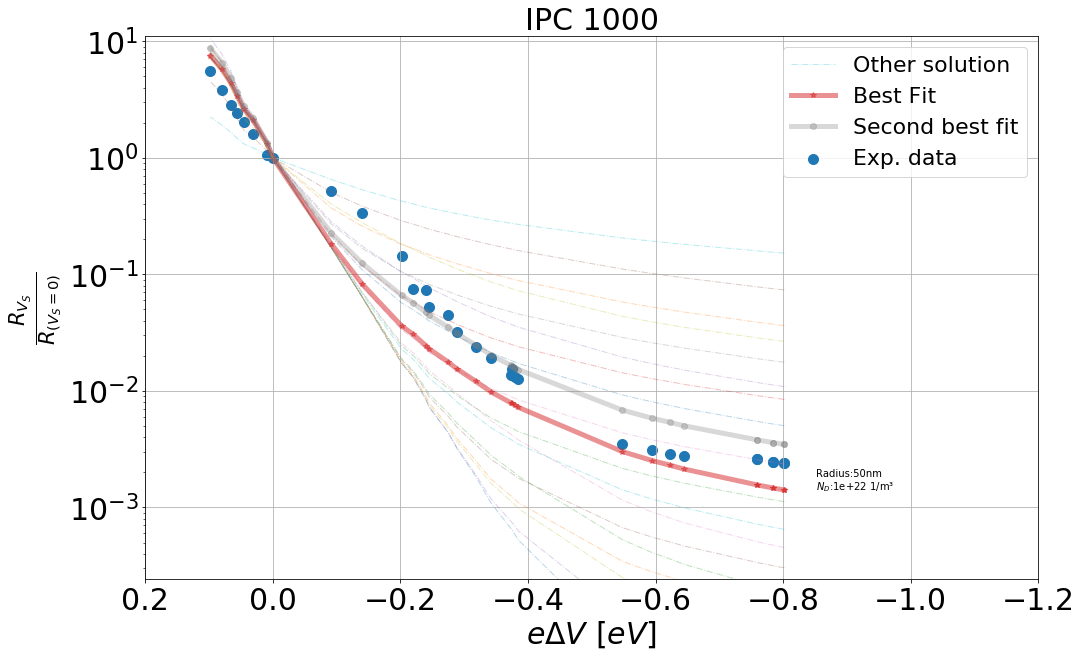

In [52]:
fig, axe = subplots(figsize = (16,10))
#for grain_tuple in num_data_at_exp_pos_dF.keys():
for grain_tuple in sum_of_squares.index:   
    if grain_tuple == grain_min_error_tuple:
        linestyle = '*-'
        linewidth = 5
        alpha = 0.5
        label = 'Best Fit'
    elif grain_tuple in sum_of_squares_grainsize.index[0:2]:
        linestyle = '-o'
        linewidth = 5
        alpha = 0.3
        label = 'Second best fit'
    else:
        linestyle = '-.'
        linewidth = 1
        alpha = 0.3
        label = 'Other solution'

        

        
    axe.plot(num_data_at_exp_pos_dF.index,
                num_data_at_exp_pos_dF[grain_tuple],
            linestyle, linewidth=linewidth, alpha = alpha,
            label =label)
    

    last_x  = num_data_at_exp_pos_dF.index[0] 
    last_y  = num_data_at_exp_pos_dF.iloc[0][grain_tuple]
    
    if grain_tuple in sum_of_squares_grainsize.index[0:1]:
        axe.text(last_x-0.05,last_y,
            f'''Radius:{grain_tuple[1]*1e9:.0f}nm\n$N_D$:{grain_tuple[2]:.2} 1/m³''')
format_axe(axe)

axe.scatter(rel_res_exp.index,
            rel_res_exp,
            s=100,
            label = 'Exp. data'
           )

axe.set_ylim(rel_res_exp.min()/10,
             rel_res_exp.max()*2);


l = {h[1]:h[0] for h in zip(*axe.get_legend_handles_labels())}.keys()
h = {h[1]:h[0] for h in zip(*axe.get_legend_handles_labels())}.values()
axe.legend(h,l,loc=1, fontsize = 22)
axe.set_title(sens, fontsize = 30)

\begin{center}
Comparison of the numerical results with the experimental data points
\end{center}

## Summary
We can see, that both fits do not fit perfectly to the experimental data. One obvious reason is the coarse screening of the grain size and and $N_D$. A second iteration of creating models with radii between 50nm and 100nm might find a  better fit. Also a finer screening of $N_D$ will turn out to be helpful for a better result.
On the other side the fitting shows, that the experimental data fits will to a grain with approximately 50nm radius and a defect concentration of around $N_D=1*10^{22} 1/m³$ at 300°C.

# Second iteration
With the approximate values of the correct model, the prvious steps of creating a look-up table for multiple model is repeated. This steps is not shown in this work. Basically the screening of the parameters is limited to grains with a radius of 55 nm and a value of $N_D$ between $1\times10^{21}$ and $1\times10^{23}$. For the second iteration 20 values between these boundaries have been selected. The points are evently spaced on a logarithmic scale. The `numpy` function `logspace` was used for this purpose.

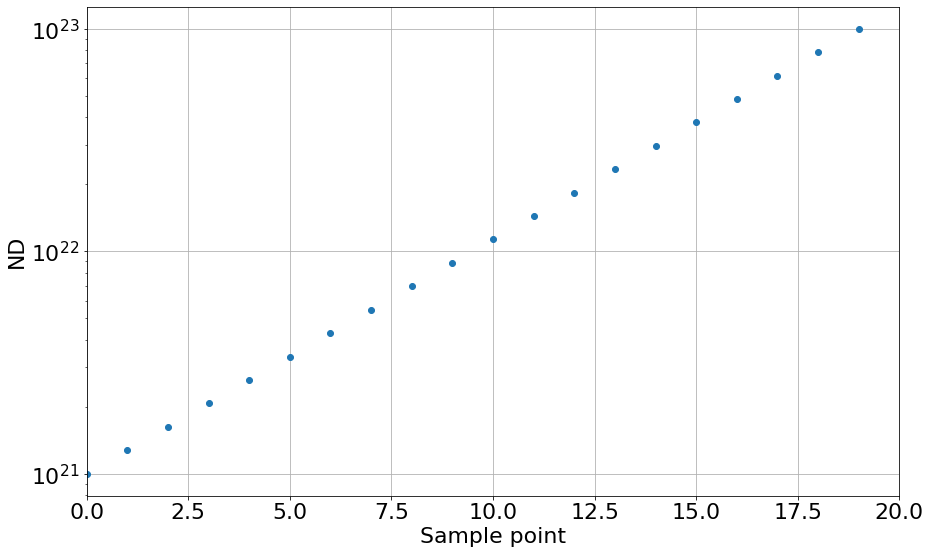

In [7]:
NDs = np.logspace(21,23,20)
fig, axe = subplots(figsize=((1+5**0.5)/2*9,9))
axe.plot(NDs,'o')
axe.set_yscale('log')
axe.set_ylabel('ND', fontsize = 22)
axe.set_xlabel('Sample point', fontsize = 22)
axe.set_xlim(0,20)
axe.tick_params(axis='both', which='both', labelsize=22)
axe.grid()

The results from the new numerical calculation are saved in a file called "numerical_sol_4_part_4_ipc1000_55nm.h5" and will be loaded in the next cell. For refitting the results the above procedure is repeated with the new numerical dataset. The required steps to fit the date and represent the results a are exported in a new function called `fit_exp_with_num_data`. This function needs the exp. dataset, the numerical dataset, a title for the figure and additionally a text for the caption. WIth these arguments the output of the fit is represented in the notebook.

In [8]:
%load_ext autoreload
%autoreload 2

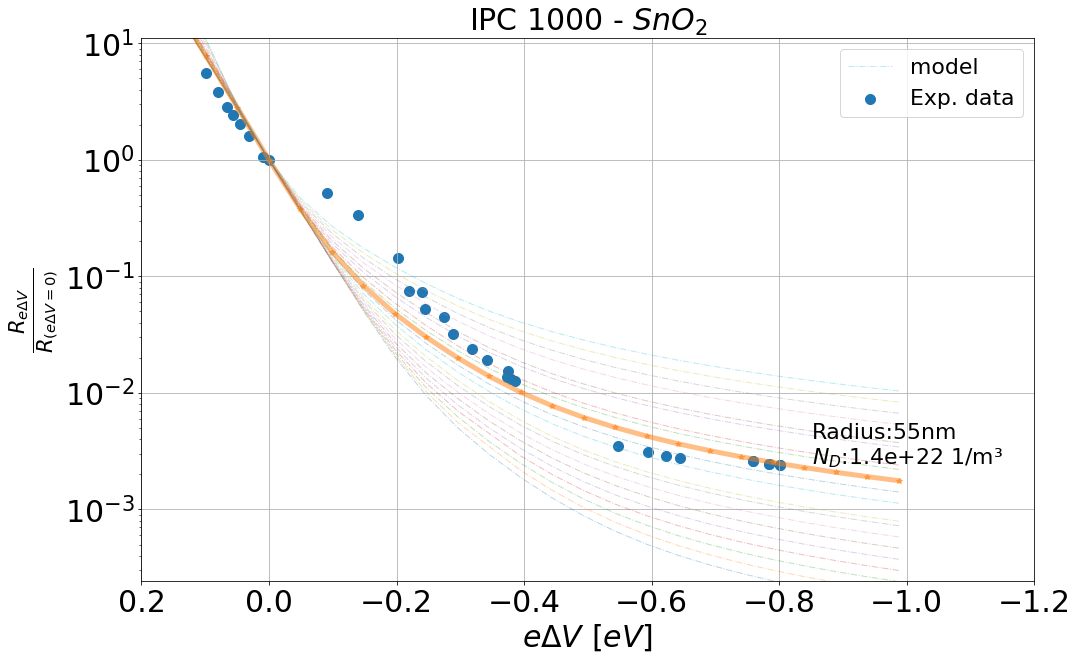

,error,T [°C],Radius [nm],$N_D$ [$1/m³$]
0,4.427580,300.0,55.0,1.438450e+22
1,4.782059,300.0,55.0,1.128838e+22
2,5.665853,300.0,55.0,1.832981e+22
3,5.986754,300.0,55.0,8.858668e+21
4,6.967131,300.0,55.0,2.335721e+22
5,8.322148,300.0,55.0,6.951928e+21
6,9.304737,300.0,55.0,5.455595e+21
7,10.971085,300.0,55.0,4.281332e+21
8,12.569745,300.0,55.0,3.359818e+21
9,13.993224,300.0,55.0,2.636651e+21


<IPython.core.display.Latex object>

,IPC 1000 - $SnO_2$
$E_C$ - $E_F$,0.29 eV
$N_D$,1.44e+22 1/m³
$n_b$,2.87e+22 1/m³
$L_D$,30.60 nm


<IPython.core.display.Latex object>

In [69]:
from IPython.display import display, Math, Latex
from fit_exp_data import fit_exp_with_num_data


calc_dF = pd.read_hdf('numerical_sol_4_part_4_ipc1000_55nm.h5','raw')

#calc_dF = pd.read_hdf('numerical_sol.h5','raw')
dF_exp = pd.read_excel('Kelvin_Data.xlsx', sheet_name='ipc1000').sort_values(by='dV')


caption_figure = 'Optimized fit with a finer screening of the parameters'
sens = 'IPC 1000 - $SnO_2$'
bf = fit_exp_with_num_data(dF_exp, calc_dF, sens=sens, caption_figure='Best fit results with finer screening of parameters.')

# Results for a commercial available $SnO_2$
In the thesis of Julia Rebholz <cite data-cite="Rebholz2016a">(Influence of Conduction Mechanism Changes and Related Effects on the Sensing Performance of Metal Oxide Based Gas Sensors, 2016)</cite> the 
commercially available $"SnO_2"$ from Sigmar Aldrich was also tested. In the next part experimental results from simultaneous work function and resistance measurements are being fitted with numerical results. The average grain radius of this material is around 50nm

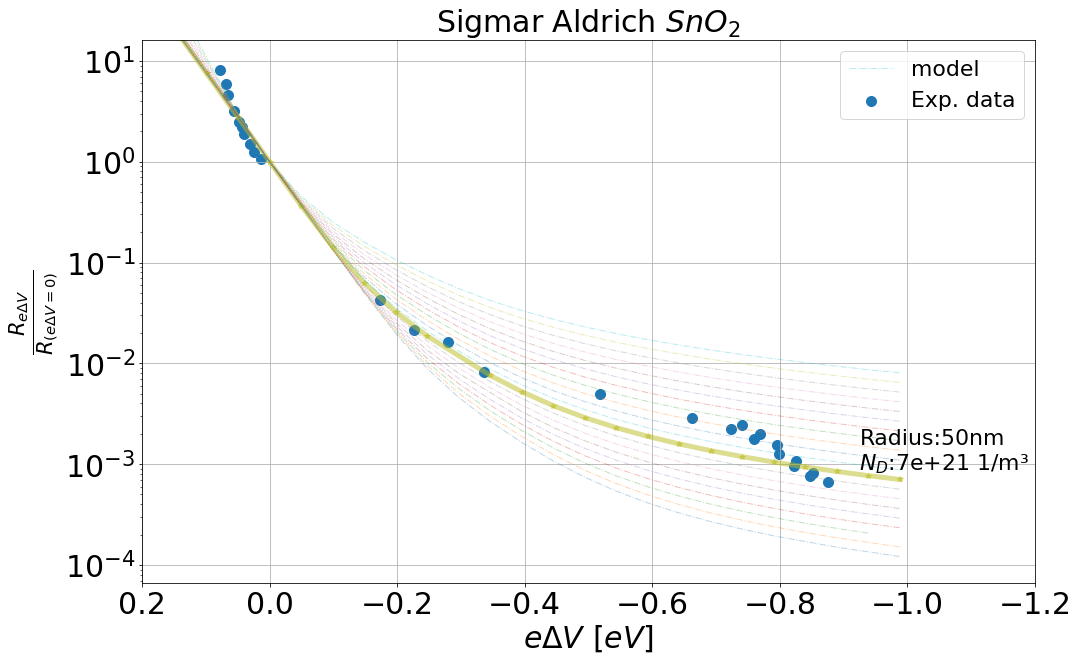

,error,T [°C],Radius [nm],$N_D$ [$1/m³$]
0,2.379963,300.0,50.0,6.951928e+21
1,2.546552,300.0,50.0,8.858668e+21
2,3.129596,300.0,50.0,5.455595e+21
3,4.300544,300.0,50.0,4.281332e+21
4,4.370771,300.0,50.0,1.128838e+22
5,5.592128,300.0,50.0,3.359818e+21
6,6.953802,300.0,50.0,2.636651e+21
7,8.195738,300.0,50.0,2.069138e+21
8,9.110344,300.0,50.0,1.438450e+22
9,9.314258,300.0,50.0,1.623777e+21


<IPython.core.display.Latex object>

,Sigmar Aldrich $SnO_2$
$E_C$ - $E_F$,0.33 eV
$N_D$,6.95e+21 1/m³
$n_b$,1.39e+22 1/m³
$L_D$,44.01 nm


<IPython.core.display.Latex object>

In [67]:
from IPython.display import display, Math, Latex
from fit_exp_data import *


calc_dF = pd.read_hdf('numerical_sol_4_part_4_SA_50nm.h5','full')

dF_exp = pd.read_excel('Kelvin_Data.xlsx', sheet_name='SA_Benni').sort_values(by='dV')


caption_figure = 'Optimized fit with a finer screening of the parameters'
sens = 'IPC 1001'
bf = fit_exp_with_num_data(dF_exp, calc_dF, sens='Sigmar Aldrich $SnO_2$', caption_figure='Best fit results with finer screening of parameters.')

# Conclusion
In this last section the calculations from the numerical model have been fine tuned for different $SnO_2$ materials. The model's parameter of the grain radius and temperature have been fixed to the values from the experimental results. Additionally the parameter of the defect concentration $N_D$ was screen in fine grained steps around the estimated value. The resulting numerical results were fitted against the experimental results. From the best fitting numerical model, otherwise hidden intrinsic properties of the semiconducting material, have be extracted.

It could be shown, that the numerical method to describe the relation between surface potential change  $\Delta V_S$ and resistance change $\Delta R$ with respect to the grain radius $R$, operation temperature $T$ and defect concentration $N_D$ is suitable to fit experimental results and gain additional information about the sensor as:

1. Distance between the conduction band ($E_C$) and the Fermi level ($E_F$)
2. Concentration of defects in the bulk $N_D$
3. Concentration of free charge carriers in the conduction band of the bulk $n_b$
3. Debye length $L_D$ of the semiconductor

# Bibliography section

%%latex
\bibliographystyle{alphadin}
\bibliography{ipython}